In [273]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM


from sklearn import preprocessing, model_selection
import tensorflow as tf

import src.lstm_helper as lh
import src.time_series_helpers as th

In [6]:
#reference:https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# https://heartbeat.fritz.ai/building-a-neural-network-from-scratch-using-python-part-1-6d399df8d432
# https://www.kaggle.com/alexdance/store-item-combination-part-6-deep-learning
# https://www.tensorflow.org/tutorials/structured_data/time_series

In [7]:
!ls src/

__pycache__            lstm_helper.py         time_series_helpers.py


In [8]:
!ls data/

lstm_data.csv         sample_submission.csv test.csv
processed_train.csv   store_item.csv        train.csv


### Predict future sales but non time-series models.

#### Fearture engineering

In [9]:
#load dataset that is processed by store by item
path = 'data/store_item.csv'
df = pd.read_csv(path)
df.shape

(1826, 501)

In [10]:
df.head()

,date,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
0,2013-01-01,13,33,15,10,11,31,25,33,18,...,12,20,24,17,45,37,11,25,17,33
1,2013-01-02,11,43,30,11,6,36,23,37,23,...,10,22,29,10,45,33,13,24,13,37
2,2013-01-03,14,23,14,8,8,18,34,38,25,...,17,27,43,20,56,28,16,29,19,46
3,2013-01-04,13,18,10,19,9,19,36,54,22,...,13,24,27,12,50,44,11,39,23,51
4,2013-01-05,10,34,23,12,8,31,38,51,29,...,14,25,31,25,62,45,16,34,22,41


In [11]:
#set datatime to index
df['date'] =  pd.to_datetime(df['date'])
df = df.set_index('date')

#### Build a  Single-output model
Single-output, multi-time-step predictions

In [12]:
# extract columns names
columns = df.columns.tolist()
columns[:5]

['s1_i1', 's1_i2', 's1_i3', 's1_i4', 's1_i5']

In [13]:
columns[0]

's1_i1'

In [18]:
# try to predict 1 year sales of item 1 at store 1
output_cols = columns[:1]

def prepare_data(df,output_cols):
    #load item 1 at store 1 sales values
    prep_df = df[output_cols]
    # convert df_1 to a dataframe
    prep_df = pd.DataFrame(prep_df)
    return prep_df

prep_df = prepare_data(df,output_cols)
prep_df.shape

(1826, 1)

In [19]:
prep_df.head()

,s1_i1
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


#### Predict  one year sales

In [135]:
# split into training, validation, and test sets.

output_length =365 # the number days we would like to predict
#time_stepts in LSTM: the recurrent cell gets unrolled to a specified length 
time_steps = 14    #recurrent cell numbers,two weeks

train_size = prep_df.shape[0] - (output_length+time_steps)
test_size  = prep_df.shape[0] - train_size
train = prep_df.iloc[:train_size,:]
test  = prep_df.iloc[-test_size:,:]
valid = prep_df.iloc[-output_length:,:]

In [138]:
print('All shapes are:    (train, ,test,valid)')
print(f'train dataset shape: {train.shape}')
print(f'test dataset shape: {test.shape}')
print(f'valid dataset shape: {valid.shape}')


All shapes are:    (train, ,test,valid)
train dataset shape: (1447, 1)
test dataset shape: (379, 1)
valid dataset shape: (365, 1)


In [139]:
# Genarate window datasets
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# The function completes that process
X_train, y_train = lh.window_generator(train, train.iloc[:,:len(output_cols)],time_steps)
X_test,  y_test  = lh.window_generator(test, test.iloc[:,:len(output_cols)],time_steps)


In [140]:
print('All shapes are: (X_train, y_train, X_test,  y_test)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}')
print(f'y_test  shape: {y_test.shape}')

All shapes are: (X_train, y_train, X_test,  y_test)
X_train shape: (1433, 14, 1)
y_train shape: (1433, 1)
X_test  shape: (365, 14, 1)
y_test  shape: (365, 1)


In [141]:
# call lstm model

model_1 = lh.lstm_model(X_train)

In [142]:
history = model_1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False)

Train on 1289 samples, validate on 144 samples
Epoch 1/30
1289/1289 [==============================] - 3s 2ms/sample - loss: 157.9311 - val_loss: 72.9147
Epoch 2/30
1289/1289 [==============================] - 2s 1ms/sample - loss: 42.8502 - val_loss: 43.0544
Epoch 3/30
1289/1289 [==============================] - 1s 1ms/sample - loss: 44.0757 - val_loss: 41.1134
Epoch 4/30
1289/1289 [==============================] - 1s 1ms/sample - loss: 44.2132 - val_loss: 40.4913
Epoch 5/30
1289/1289 [==============================] - 1s 1ms/sample - loss: 43.0273 - val_loss: 38.6091
Epoch 6/30
1289/1289 [==============================] - 1s 1ms/sample - loss: 42.0699 - val_loss: 36.9812
Epoch 7/30
1289/1289 [==============================] - 2s 1ms/sample - loss: 41.7382 - val_loss: 36.8282
Epoch 8/30
1289/1289 [==============================] - 1s 1ms/sample - loss: 39.9197 - val_loss: 35.7335
Epoch 9/30
1289/1289 [==============================] - 1s 1ms/sample - loss: 39.0749 - val_loss: 34.947

In [143]:
y_pred = model_1.predict(X_test)
y_pred.shape

(365, 1)

In [144]:
type(y_pred)

numpy.ndarray

In [150]:
RMSE  = th.rmse_calculate(df_forecast,valid)
print(RMSE)

5.623309595468694


In [151]:
df_forecast_3months = df_forecast[-92:]
valid_3months = valid[-92:]

In [152]:
RMSE_3months  = th.rmse_calculate(df_forecast_3months,valid_3months)
print(RMSE_3months)

5.377468583055339


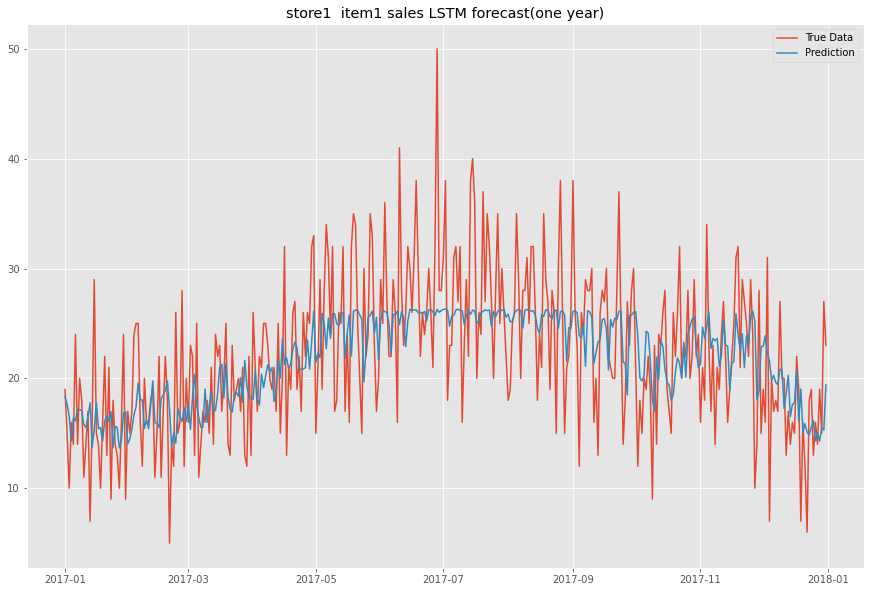

Plot saved.


In [156]:
#plot forecast VS actuals

figtitle = 'store1  item1 sales LSTM forecast(one year)'
th.plot_results(df_forecast, valid, figtitle)



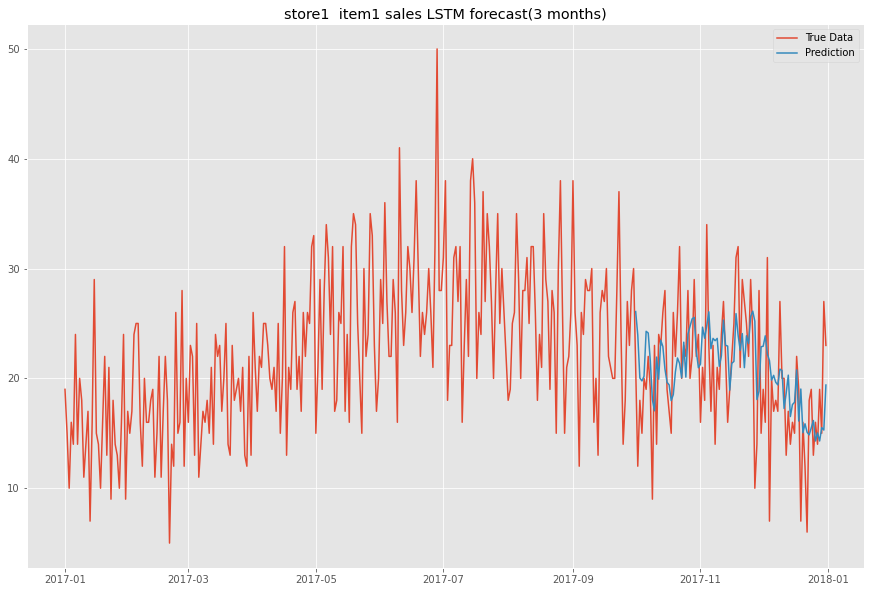

Plot saved.


In [157]:
figtitle = 'store1  item1 sales LSTM forecast(3 months)'
th.plot_results(df_forecast_3months, valid, figtitle)

#### Predict  one year sales

In [158]:
#### Predict next 3 months sales
prep_df.head()

,s1_i1
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [195]:
# split into training, validation, and test sets.
output_cols = columns[:1]
output_length =92 # the number days we would like to predict
#time_stepts in LSTM: the recurrent cell gets unrolled to a specified length 
time_steps = 14    #recurrent cell numbers,two weeks

train,test,valid = lh.split_data(prep_df,output_length, time_steps)

In [196]:
print('All shapes are:    (train, ,test, valid)')
print(f'train dataset shape: {train.shape}')
print(f'test dataset shape: {test.shape}')
print(f'valid dataset shape: {valid.shape}')

All shapes are:    (train, ,test, valid)
train dataset shape: (1720, 1)
test dataset shape: (106, 1)
valid dataset shape: (92, 1)


In [197]:
# Genarate window datasets
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# The function completes that process
X_train, y_train = lh.window_generator(train, train.iloc[:,:len(output_cols)],time_steps)
X_test,  y_test  = lh.window_generator(test, test.iloc[:,:len(output_cols)],time_steps)

print('All shapes are: (X_train, y_train, X_test,  y_test)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}')
print(f'y_test  shape: {y_test.shape}')

All shapes are: (X_train, y_train, X_test,  y_test)
X_train shape: (1706, 14, 1)
y_train shape: (1706, 1)
X_test  shape: (92, 14, 1)
y_test  shape: (92, 1)


In [198]:
# call lstm model
model_1 = lh.lstm_model(X_train)
history = model_1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False)

Train on 1535 samples, validate on 171 samples
Epoch 1/30
1535/1535 [==============================] - 4s 2ms/sample - loss: 87.0455 - val_loss: 63.2416
Epoch 2/30
1535/1535 [==============================] - 2s 1ms/sample - loss: 43.5824 - val_loss: 61.8355
Epoch 3/30
1535/1535 [==============================] - 2s 1ms/sample - loss: 41.8215 - val_loss: 59.5731
Epoch 4/30
1535/1535 [==============================] - 2s 1ms/sample - loss: 40.5179 - val_loss: 56.5234
Epoch 5/30
1535/1535 [==============================] - 2s 1ms/sample - loss: 39.6954 - val_loss: 56.4867
Epoch 6/30
1535/1535 [==============================] - 2s 1ms/sample - loss: 38.8973 - val_loss: 55.4649
Epoch 7/30
1535/1535 [==============================] - 2s 1ms/sample - loss: 37.7273 - val_loss: 57.1044
Epoch 8/30
1535/1535 [==============================] - 2s 1ms/sample - loss: 37.0061 - val_loss: 54.6262
Epoch 9/30
1535/1535 [==============================] - 2s 1ms/sample - loss: 36.4687 - val_loss: 57.6292

In [199]:
y_pred = model_1.predict(X_test)
y_pred.shape

(92, 1)

In [200]:
df_forecast = pd.DataFrame(y_pred, index=valid.index, columns=valid.columns + '_forecast')
df_forecast

,s1_i1_forecast
date,
2017-10-01,24.984232
2017-10-02,22.314299
2017-10-03,19.118536
2017-10-04,18.986210
2017-10-05,18.168827
...,...
2017-12-27,15.083748
2017-12-28,14.264614
2017-12-29,15.683655


In [203]:
RMSE_3months  = th.rmse_calculate(df_forecast,valid)
print(RMSE_3months)

5.33


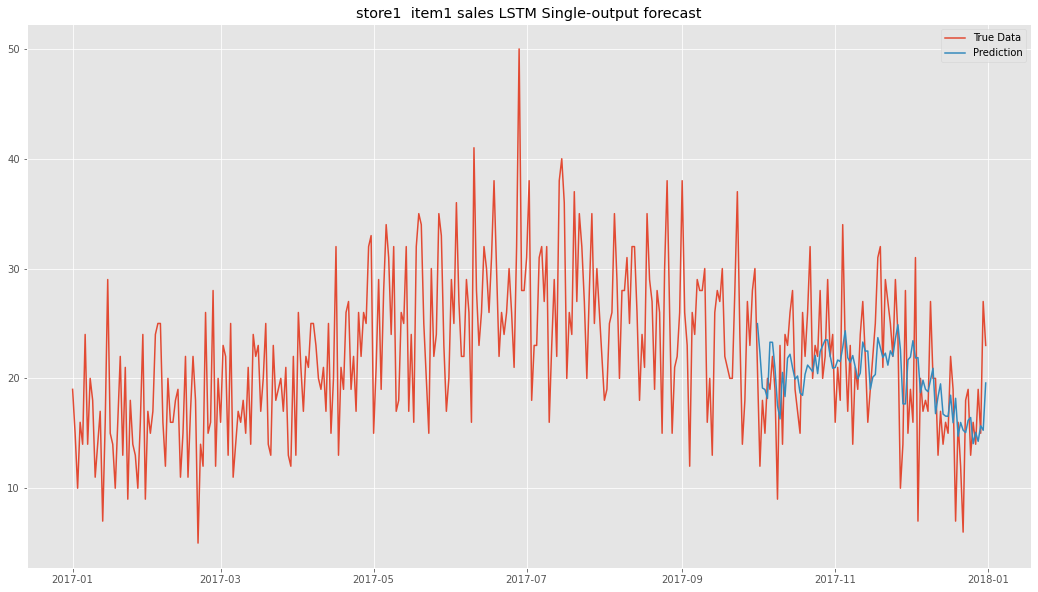

Plot saved.


In [204]:
#plot forecast VS actuals

figtitle = 'store1  item1 sales LSTM Single-output forecast'
th.plot_results(df_forecast, prep_df['2017-1-1':], figtitle)



#### Build a  multi-output predictions
multi-output predictions.

In [336]:
# predict 3 months sales for 500 store-item 
df.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,12,20,24,17,45,37,11,25,17,33
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,10,22,29,10,45,33,13,24,13,37
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,17,27,43,20,56,28,16,29,19,46
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,13,24,27,12,50,44,11,39,23,51
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,14,25,31,25,62,45,16,34,22,41


In [337]:
# split into training, validation, and test sets.
output_cols = df.columns.tolist()
output_length =92 # the number days we would like to predict
#time_stepts in LSTM: the recurrent cell gets unrolled to a specified length 
time_steps = 14    #recurrent cell numbers,two weeks

train,test,valid = lh.split_data(df,output_length, time_steps)

In [338]:
print('All shapes are:    (train, ,test, valid,labels)')
print(f'train dataset shape: {train.shape}')
print(f'test dataset shape : {test.shape}')
print(f'valid dataset shape: {valid.shape}')
print(f'labels width       : {len(output_cols)}')

All shapes are:    (train, ,test, valid,labels)
train dataset shape: (1720, 500)
test dataset shape : (106, 500)
valid dataset shape: (92, 500)
labels width       : 500


In [339]:
# Genarate window datasets
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# The function completes that process
X_train, y_train = lh.window_generator(train, train.iloc[:,:len(output_cols)],time_steps)
X_test,  y_test  = lh.window_generator(test, test.iloc[:,:len(output_cols)],time_steps)

print('All shapes are: (X_train, y_train, X_test,  y_test)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}')
print(f'y_test  shape: {y_test.shape}')

All shapes are: (X_train, y_train, X_test,  y_test)
X_train shape: (1706, 14, 500)
y_train shape: (1706, 500)
X_test  shape: (92, 14, 500)
y_test  shape: (92, 500)


In [341]:
# call lstm model
lstm_units = 500*16
model = Sequential()
model.add(LSTM(
            units = lstm_units,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=False
            ))
model.add(Activation("tanh"))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]*4))

model.add(Dense(units=X_train.shape[2]*2))
model.add(Dense(units=X_train.shape[2]))
model.compile(
                loss='mse',
                optimizer="rmsprop") 

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=100,
    validation_split=0.05,
    verbose=1,
    shuffle=False)

Train on 1620 samples, validate on 86 samples
Epoch 1/60


In [325]:
y_pred = model.predict(X_test)
y_pred.shape

(92, 500)

In [326]:
df_forecast = pd.DataFrame(y_pred, index=valid.index, columns=valid.columns + '_forecast')
df_forecast

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast,...,s10_i41_forecast,s10_i42_forecast,s10_i43_forecast,s10_i44_forecast,s10_i45_forecast,s10_i46_forecast,s10_i47_forecast,s10_i48_forecast,s10_i49_forecast,s10_i50_forecast
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,17.748293,48.795246,32.659077,22.385561,16.254774,51.571949,50.206551,66.990746,44.655945,64.462204,...,25.384054,39.614151,55.915699,33.055531,88.213684,63.493698,25.120142,55.633915,31.963448,70.972458
2017-10-02,17.748293,48.795246,32.659077,22.385561,16.254774,51.571949,50.206551,66.990746,44.655945,64.462204,...,25.384054,39.614151,55.915699,33.055531,88.213684,63.493698,25.120142,55.633915,31.963448,70.972458
2017-10-03,17.748293,48.795246,32.659077,22.385561,16.254774,51.571949,50.206551,66.990746,44.655945,64.462204,...,25.384054,39.614151,55.915699,33.055531,88.213684,63.493698,25.120142,55.633915,31.963448,70.972458
2017-10-04,17.748293,48.795246,32.659077,22.385561,16.254774,51.571949,50.206551,66.990746,44.655945,64.462204,...,25.384054,39.614151,55.915699,33.055531,88.213684,63.493698,25.120142,55.633915,31.963448,70.972458
2017-10-05,17.748293,48.795246,32.659077,22.385561,16.254774,51.571949,50.206551,66.990746,44.655945,64.462204,...,25.384054,39.614151,55.915699,33.055531,88.213684,63.493698,25.120142,55.633915,31.963448,70.972458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,17.748293,48.795246,32.659077,22.385561,16.254774,51.571949,50.206551,66.990746,44.655945,64.462204,...,25.384054,39.614151,55.915699,33.055531,88.213684,63.493698,25.120142,55.633915,31.963448,70.972458
2017-12-28,17.748293,48.795246,32.659077,22.385561,16.254774,51.571949,50.206551,66.990746,44.655945,64.462204,...,25.384054,39.614151,55.915699,33.055531,88.213684,63.493698,25.120142,55.633915,31.963448,70.972458
2017-12-29,17.748293,48.795246,32.659077,22.385561,16.254774,51.571949,50.206551,66.990746,44.655945,64.462204,...,25.384054,39.614151,55.915699,33.055531,88.213684,63.493698,25.120142,55.633915,31.963448,70.972458


In [327]:
RMSE_s1_i1  = th.rmse_calculate(df_forecast.iloc[:,0],valid.iloc[:,0])
print(RMSE_s1_i1)

6.33


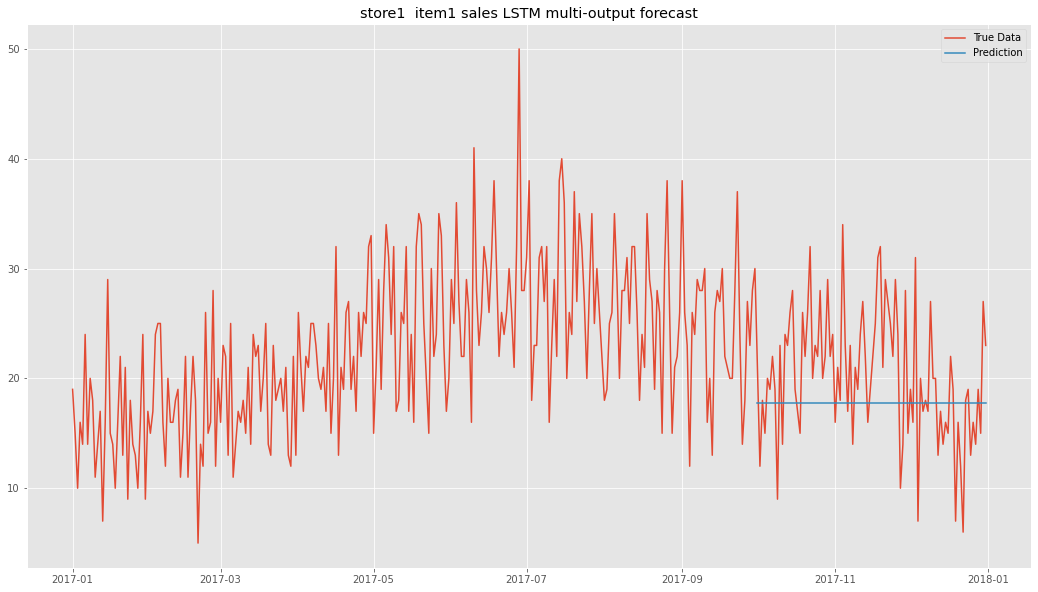

Plot saved.


In [328]:
#plot forecast VS actuals

figtitle = 'store1  item1 sales LSTM multi-output forecast'
th.plot_results(df_forecast.iloc[:,0], df.iloc[-365:,0], figtitle)



In [329]:
RMSE_s1_i2  = th.rmse_calculate(df_forecast.iloc[:,1],valid.iloc[:,1])
print(RMSE_s1_i2)

13.37


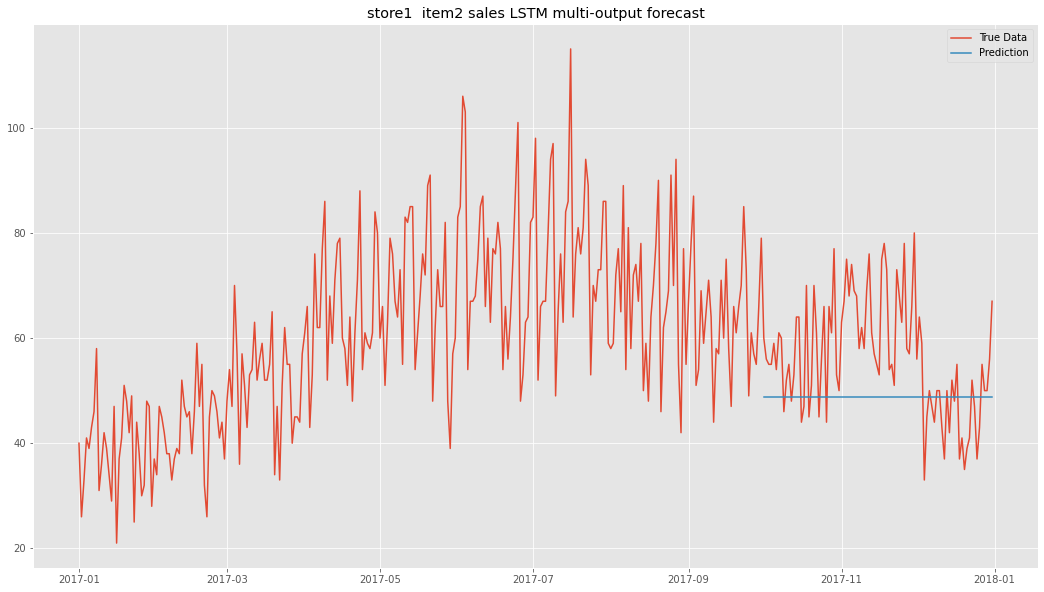

Plot saved.


In [330]:
#plot forecast VS actuals

figtitle = 'store1  item2 sales LSTM multi-output forecast'
th.plot_results(df_forecast.iloc[:,1], df.iloc[-365:,1], figtitle)


In [331]:
RMSE_s1_i3  = th.rmse_calculate(df_forecast.iloc[:,2],valid.iloc[:,2])
print(RMSE_s1_i3)

8.11


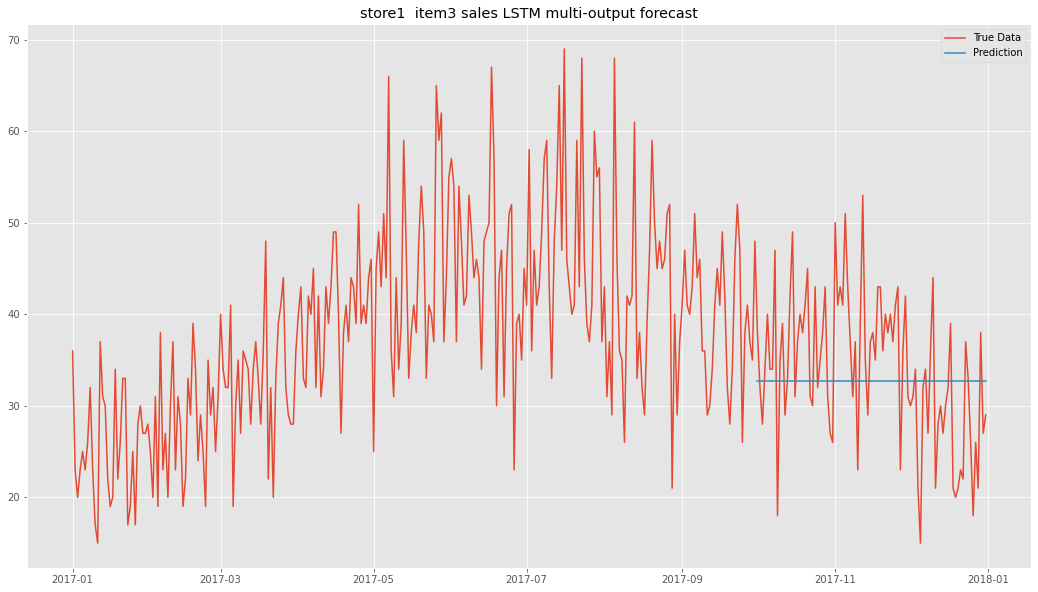

Plot saved.


In [332]:
#plot forecast VS actuals

figtitle = 'store1  item3 sales LSTM multi-output forecast'
th.plot_results(df_forecast.iloc[:,2], df.iloc[-365:,2], figtitle)


13.37


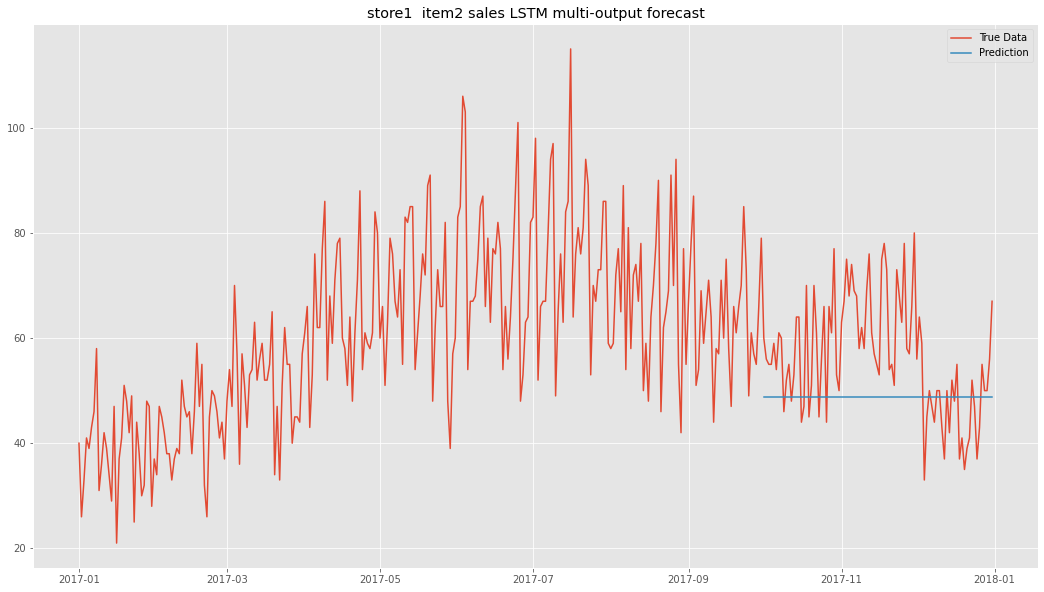

Plot saved.


In [333]:
RMSE_s1_i2  = th.rmse_calculate(df_forecast.iloc[:,1],valid.iloc[:,1])
print(RMSE_s1_i2)

#plot forecast VS actuals

figtitle = 'store1  item2 sales LSTM multi-output forecast'
th.plot_results(df_forecast.iloc[:,1], df.iloc[-365:,1], figtitle)


### 10 output

In [241]:
# predict 3 months sales for 10 store-item 
df.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,12,20,24,17,45,37,11,25,17,33
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,10,22,29,10,45,33,13,24,13,37
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,17,27,43,20,56,28,16,29,19,46
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,13,24,27,12,50,44,11,39,23,51
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,14,25,31,25,62,45,16,34,22,41


In [302]:
# sampling = random.choices(np.arange(df.shape[1]), k=3)
sampling =np.arange(10)
sampling

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [303]:
df_10 = df.iloc[:,sampling]
df_10.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10
date,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37
2013-01-02,11,43,30,11,6,36,23,37,23,34
2013-01-03,14,23,14,8,8,18,34,38,25,32
2013-01-04,13,18,10,19,9,19,36,54,22,45
2013-01-05,10,34,23,12,8,31,38,51,29,35


In [304]:
# split into training, validation, and test sets.
output_cols = df_10.columns.tolist()
output_length =92 # the number days we would like to predict
#time_stepts in LSTM: the recurrent cell gets unrolled to a specified length 
time_steps = 14    #recurrent cell numbers,two weeks

train,test,valid = lh.split_data(df_10,output_length, time_steps)

In [305]:
print('All shapes are:    (train, ,test, valid,labels)')
print(f'train dataset shape: {train.shape}')
print(f'test dataset shape : {test.shape}')
print(f'valid dataset shape: {valid.shape}')
print(f'labels width       : {len(output_cols)}')

All shapes are:    (train, ,test, valid,labels)
train dataset shape: (1720, 10)
test dataset shape : (106, 10)
valid dataset shape: (92, 10)
labels width       : 10


In [306]:
# Genarate window datasets
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# The function completes that process
X_train, y_train = lh.window_generator(train, train.iloc[:,:len(output_cols)],time_steps)
X_test,  y_test  = lh.window_generator(test, test.iloc[:,:len(output_cols)],time_steps)

print('All shapes are: (X_train, y_train, X_test,  y_test)')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}')
print(f'y_test  shape: {y_test.shape}')

All shapes are: (X_train, y_train, X_test,  y_test)
X_train shape: (1706, 14, 10)
y_train shape: (1706, 10)
X_test  shape: (92, 14, 10)
y_test  shape: (92, 10)


In [307]:
# call lstm model
lstm_units = 128*2
model = Sequential()
model.add(LSTM(
            units = lstm_units,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=False
            ))
model.add(Activation("tanh"))
model.add(Dropout(0.2))

model.add(Dense(units=X_train.shape[2]*2))
model.add(Dense(units=X_train.shape[2]))
model.compile(
                loss='mse',
                optimizer="rmsprop") 

In [308]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=30,
    validation_split=0.1,
    verbose=1,
    shuffle=False)

Train on 1535 samples, validate on 171 samples
Epoch 1/30
1535/1535 [==============================] - 6s 4ms/sample - loss: 1315.2931 - val_loss: 1660.4148
Epoch 2/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 428.5761 - val_loss: 618.2441
Epoch 3/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 181.3464 - val_loss: 350.9675
Epoch 4/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 128.6835 - val_loss: 275.3273
Epoch 5/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 114.7626 - val_loss: 244.9199
Epoch 6/30
1535/1535 [==============================] - 4s 2ms/sample - loss: 104.3828 - val_loss: 239.6310
Epoch 7/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 103.2147 - val_loss: 269.0658
Epoch 8/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 102.6550 - val_loss: 240.1369
Epoch 9/30
1535/1535 [==============================] - 3s 2ms/sample - loss: 99.6636 -

In [309]:
y_pred = model.predict(X_test)
y_pred.shape

(92, 10)

In [310]:
y_pred[:5]

array([[21.639471, 57.229393, 35.9271  , 21.742556, 18.197311, 57.734966,
        57.401237, 75.27708 , 50.670048, 71.80933 ],
       [21.23117 , 56.29621 , 35.29818 , 21.47353 , 17.91232 , 56.826565,
        56.2264  , 73.94677 , 49.544106, 70.45454 ],
       [18.232134, 48.430073, 30.482931, 18.52815 , 15.393649, 49.357338,
        48.374016, 63.951233, 42.755535, 60.83514 ],
       [18.953043, 50.094658, 31.701136, 19.212152, 16.172628, 50.847374,
        50.10913 , 66.01328 , 44.44132 , 62.99688 ],
       [19.539143, 52.04225 , 32.537952, 19.814913, 16.563248, 52.55223 ,
        52.018936, 68.64944 , 45.86916 , 65.32976 ]], dtype=float32)

In [311]:
df_forecast = pd.DataFrame(y_pred, index=valid.index, columns=valid.columns + '_forecast')
df_forecast

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast
date,,,,,,,,,,
2017-10-01,21.639471,57.229393,35.927101,21.742556,18.197311,57.734966,57.401237,75.277077,50.670048,71.809334
2017-10-02,21.231171,56.296211,35.298180,21.473530,17.912319,56.826565,56.226398,73.946770,49.544106,70.454536
2017-10-03,18.232134,48.430073,30.482931,18.528151,15.393649,49.357338,48.374016,63.951233,42.755535,60.835140
2017-10-04,18.953043,50.094658,31.701136,19.212152,16.172628,50.847374,50.109131,66.013283,44.441319,62.996880
2017-10-05,19.539143,52.042252,32.537952,19.814913,16.563248,52.552231,52.018936,68.649437,45.869160,65.329758
...,...,...,...,...,...,...,...,...,...,...
2017-12-27,16.734932,44.456825,27.904211,16.990070,14.234917,45.069050,44.644638,58.621170,39.415051,56.217117
2017-12-28,17.971952,48.007462,30.173500,18.426435,15.356324,48.671356,48.208134,63.263844,42.558983,60.542374
2017-12-29,17.595655,47.342861,29.997154,18.152037,15.132036,48.217186,47.610451,62.438038,42.066845,59.707840


In [312]:
RMSE_s1_i1  = th.rmse_calculate(df_forecast.iloc[:,0],valid.iloc[:,0])
print(RMSE_s1_i1)

5.46


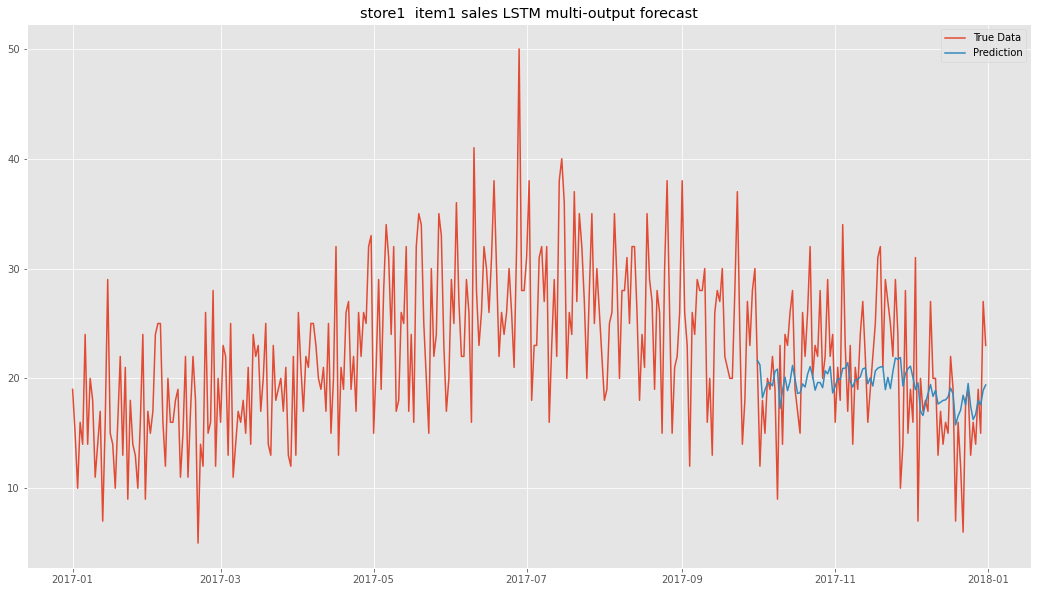

Plot saved.


In [313]:
#plot forecast VS actuals

figtitle = 'store1  item1 sales LSTM multi-output forecast'
th.plot_results(df_forecast.iloc[:,0], df.iloc[-365:,0], figtitle)



In [314]:
RMSE_s1_i2  = th.rmse_calculate(df_forecast.iloc[:,1],valid.iloc[:,1])
print(RMSE_s1_i2)

10.46


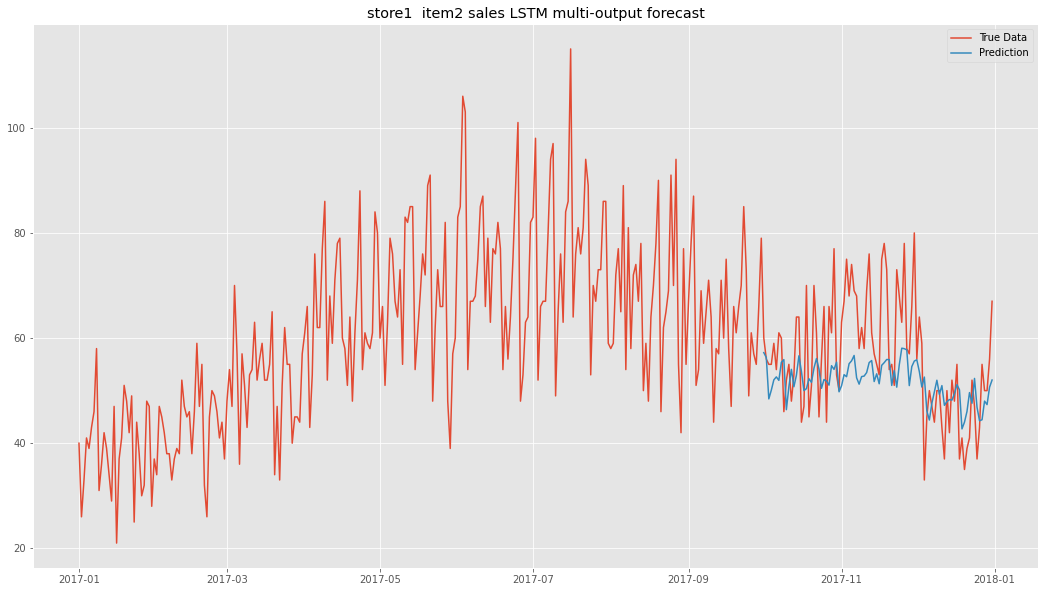

Plot saved.


In [315]:
#plot forecast VS actuals

figtitle = 'store1  item2 sales LSTM multi-output forecast'
th.plot_results(df_forecast.iloc[:,1], df.iloc[-365:,1], figtitle)


In [316]:
RMSE_s1_i3  = th.rmse_calculate(df_forecast.iloc[:,2],valid.iloc[:,2])
print(RMSE_s1_i3)

7.41


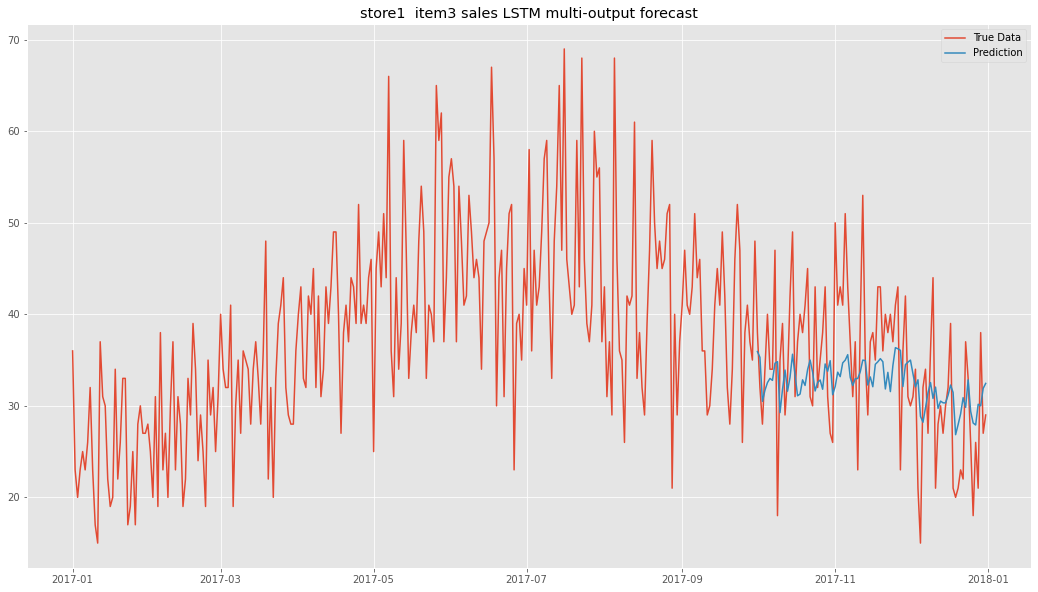

Plot saved.


In [317]:
#plot forecast VS actuals

figtitle = 'store1  item3 sales LSTM multi-output forecast'
th.plot_results(df_forecast.iloc[:,2], df.iloc[-365:,2], figtitle)


10.46


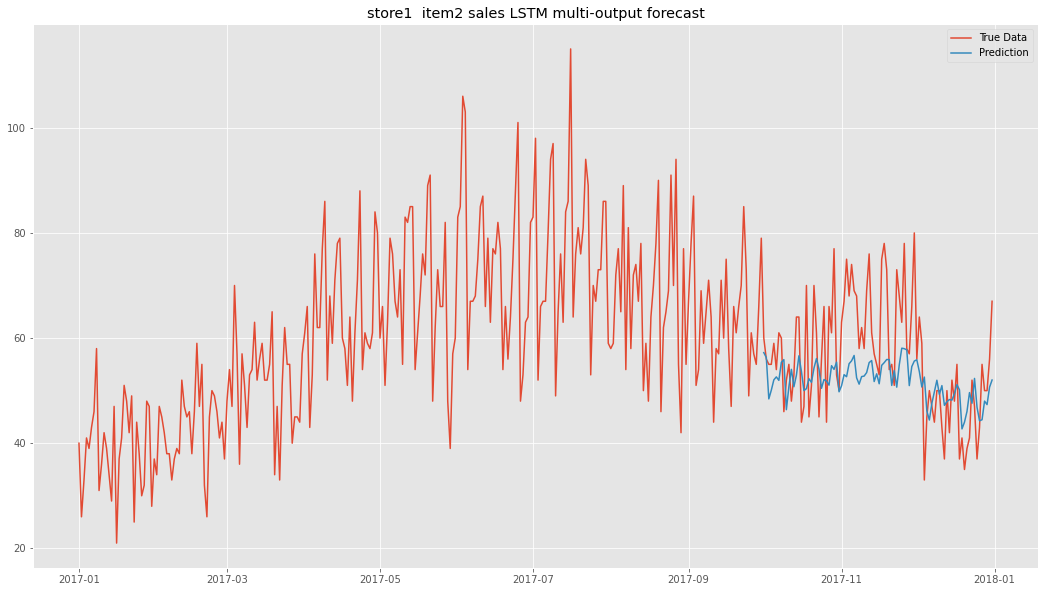

Plot saved.


In [318]:
RMSE_s1_i2  = th.rmse_calculate(df_forecast.iloc[:,1],valid.iloc[:,1])
print(RMSE_s1_i2)

#plot forecast VS actuals

figtitle = 'store1  item2 sales LSTM multi-output forecast'
th.plot_results(df_forecast.iloc[:,1], df.iloc[-365:,1], figtitle)
